<a href="https://colab.research.google.com/github/hayatrajani/reinforcement-learning/blob/main/Policy_and_Value_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline
np.set_printoptions(linewidth=np.inf)

# Design the Grid World

![Grid World](https://drive.google.com/uc?id=1vFtvKmOCfYnLVTMyQGJD3cNk0AkItm0-)

The agent may start in any cell.

When it reaches cell $G$, it will receive $100$ points and the episode ends.

When it reaches a cell marked $*$, it will receive $10$ points and the episode continues.

When it attempts to enter a cell marked $X$, it will receive $-20$ points and stay in the cell it came
from.

When it attempts to leave the grid, it will receive $-30$ points and stay where it is.

All actions entering an unmarked cell will receive $-1$ point.

In [ ]:
gridSize = (9,9)

offGridReward = -30
obstacleReward = -20
starReward = 10
goalReward = 100

rewards = np.zeros(gridSize)-1

obstacles = (
    (1,5), (1,7),
    (2,1), (2,2), (2,3), (2,4), (2,5), (2,7),
    (3,1), (3,6),
    (4,3), (4,4), (4,5), 
    (5,7),
    (6,1), (6,2), (6,3), (6,4), (6,5), (6,6),
    (7,8),
    (8,4), (8,8)
)
for cell in obstacles:
    rewards[cell] = obstacleReward

stars = (
    (0,0), (0,1), (0,2), (0,7), (0,8),
    (1,8),
    (3,2), (3,3), (3,4), (3,5),
    (4,2),
    (7,1), (7,2), (7,3), (7,4), (7,5), (7,6),
    (8,1), (8,2), (8,3), (8,5), (8,6)
)
for cell in stars:
    rewards[cell] = starReward

goal = ((3,8),)
for cell in goal:
    rewards[cell] = goalReward
        

# define the actions N, S, E, W, NE, NW, SE, SW - indexed sequentially
# action E (move right) indexed at 2
allActions = ((-1,0), (1,0), (0,1), (0,-1), (-1,1), (-1,-1), (1,1), (1,-1))


def initPolicy(actions):
    # Choose a random action with probability 0.5 and otherwise move right
    nActions = len(actions)
    action_prob = np.zeros((*gridSize, nActions))   # shape: H x W x Actions
    for action in actions:
        action_prob[:,:,action] += 0.5+(0.5/nActions) if action == 2 else 0.5/nActions
    for s in np.ndindex(gridSize):
        if rewards[s] in (obstacleReward,goalReward):
            action_prob[s] = 0
    return action_prob


def step(state, action, deterministic=True):
    # all actions take place with probability 1
    if deterministic:
        nextState = (state[0] + action[0], state[1] + action[1])    
        # Check if agent is within the grid
        if 0 <= nextState[0] < gridSize[0] and 0 <= nextState[1] < gridSize[1]:
            reward = rewards[nextState]
            # if the agent attempts to enter cell marked X, -20 points and
            # it stays in the same cell it came from
            if reward == obstacleReward:
                return [(state, 1, reward)]
            else:
                return [(nextState, 1, reward)]
        # Penalty if the agent leaves the grid
        else:
            return [(state, 1, offGridReward)]
    # desired action only takes place with probability 0.8
    # with probability 0.1, agent deviates 45 deg left, or
    # with probability 0.1, 45 deg right of desired action
    else:
        returns = []
        for thetaDev, trans_prob in ((0,0.8), (-np.pi/4,0.1), (np.pi/4,0.1)):
            rotMat = np.array([[np.cos(thetaDev),-np.sin(thetaDev)],
                               [np.sin(thetaDev),np.cos(thetaDev)]])
            action = np.round(rotMat @ action).astype(int)
            nextState, _, reward = step(state, action, deterministic=True)[0]
            returns.append((nextState, trans_prob, reward))
        return returns


def policyEvaluation(policy, actions, V = np.zeros(gridSize), gamma=0.9, theta=1e-4, deterministic=True):
    # repeat
    while True:
        delta = 0
        # for each state s
        for s in np.ndindex(gridSize):
            # if not terminal state (cells marked with G or X) i.e.
            # a state in which the agent can perform a valid action
            if rewards[s] not in (obstacleReward,goalReward):
                # update the state value via a full width one step look ahead backup
                v = 0
                action_prob = policy[s]
                # for each possible action from state s
                for a in actions:
                    # for each possible successor state resulting from action a
                    for s_, trans_prob, reward in step(s, allActions[a], deterministic):
                        # sum up the immediate rewards and discounted successor state values
                        # weighted by the respective transition and action probabilities
                        v += action_prob[a]*trans_prob*(reward + gamma*V[s_])
                # get the maximum difference in state values
                delta = max(delta, abs(V[s]-v))
                V[s] = v
        # until maximum change in state values goes below threshold
        if delta < theta:
            break
    return V


def lookahead(state, actions, V, gamma=0.9, deterministic=True):    
    Q = np.zeros(len(actions))
    # for each possible action from state s
    for a in actions:
        # for each possible successor state resulting from action a
        for s_, trans_prob, reward in step(state, allActions[a], deterministic):
            # estimate the expected value
            Q[a] += trans_prob*(reward + gamma*V[s_])
    return Q


def policyIteration(actions, gamma=0.9, deterministic=True):
    policy = initPolicy(actions)
    V = np.zeros(gridSize)
    # repeat
    while True:
        # policy evaluation
        V = policyEvaluation(policy, actions, V=V)
        # policy improvement
        policy_stable = True
        # for each state s
        for s in np.ndindex(gridSize):
            # if not terminal state (cells marked with G or X) i.e.
            # a state in which the agent can perform a valid action
            if rewards[s] not in (obstacleReward,goalReward):
                # get the best action(s) as per current policy
                aOld = np.where(policy[s]==policy[s].max())[0]
                # estimate action values for all possible actions from state s
                Q = lookahead(s, actions, V, gamma, deterministic)
                # get the new best action(s)
                aNew = np.where(Q==Q.max())[0]
                # greedily update the policy
                if (not np.array_equal(aOld, aNew)):
                    policy_stable = False
                for a in actions:
                    policy[s][a] = 1/len(aNew) if a in aNew else 0
        # until policy converges
        if policy_stable:
            return V, policy


def valueIteration(actions, gamma=0.9, theta=1e-4, deterministic=True):
    V = np.zeros(gridSize)
    # repeat
    while True:
        delta = 0
        # for each state s
        for s in np.ndindex(gridSize):
            # if not terminal state (cells marked with G or X) i.e.
            # a state in which the agent can perform a valid action
            if rewards[s] not in (obstacleReward,goalReward):
                # estimate action values for all possible actions from state s
                Q = lookahead(s, actions, V, gamma, deterministic)
                # max over the estimated action values
                v = np.max(Q)
                # get the maximum difference in state values
                delta = max(delta, abs(V[s]-v))
                V[s] = v
        # until maximum change in state value goes below threshold
        if delta < theta:
            break
    policy = np.zeros((*gridSize, len(actions)))
    # policy update
    for s in np.ndindex(gridSize):
        # if not terminal state (cells marked with G or X) i.e.
        # a state in which the agent can perform a valid action
        if rewards[s] not in (obstacleReward,goalReward):
            # estimate action values for all possible actions from state s
            Q = lookahead(s, actions, V, gamma, deterministic)
            # greedily update the policy
            aNew = np.where(Q==Q.max())[0]
            for a in actions:
                policy[s][a] = 1/len(aNew) if a in aNew else 0
    return V, policy


def plotPolicy(policy):
    plt.rc('figure', figsize=(6,6))
    ax = plt.gca()
    ax.axis([0,gridSize[1],0,gridSize[0]])
    ax.grid(True, color='k', linewidth=1.5)
    ax.set_aspect(1)
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none')
    for s in np.ndindex(gridSize):
        if policy[s].max()==0:
            if s in goal:
                ax.add_patch(Rectangle((s[1],s[0]),1,1,color='springgreen'))
            else:
                ax.add_patch(Rectangle((s[1],s[0]),1,1,color='orangered'))
        else:
            if s in stars:
                ax.add_patch(Rectangle((s[1],s[0]),1,1,color='royalblue'))
            action = np.argmax(policy[s])
            if action==0:
                ax.arrow(s[1]+0.5,s[0]+0.8, 0,-0.6, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
            elif action==1:
                ax.arrow(s[1]+0.5,s[0]+0.2, 0,0.6, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
            elif action==2:
                ax.arrow(s[1]+0.2,s[0]+0.5, 0.6,0, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
            elif action==3:
                ax.arrow(s[1]+0.8,s[0]+0.5, -0.6,0, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
            elif action==4:
                ax.arrow(s[1]+0.25,s[0]+0.75, 0.5,-0.5, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
            elif action==5:
                ax.arrow(s[1]+0.75,s[0]+0.75, -0.5,-0.5, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
            elif action==6:
                ax.arrow(s[1]+0.25,s[0]+0.25, 0.5,0.5, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
            elif action==7:
                ax.arrow(s[1]+0.75,s[0]+0.25, -0.5,0.5, head_width=0.25, head_length=0.15,
                         linewidth=2, length_includes_head=True, fill=True)
    plt.show()

# Task 3.1

Compute the expected value of all cells for a policy that chooses with probability 0.5 a random action and otherwise moves towards the right.

In [ ]:
# only first four actions (Up, Down, Right, Left)
actions = range(4)
policy = initPolicy(actions)
V = policyEvaluation(policy, actions)
print(V)

[[ -55.75305866  -60.31658695  -76.24676467  -85.96864553  -95.1972291  -102.08834927 -109.17118645 -128.05561988 -154.37574107]
 [ -70.27159998  -71.06629982  -82.45365375  -97.07539187 -113.47895379    0.         -138.87299585    0.         -140.14102741]
 [-114.39151884    0.            0.            0.            0.            0.         -156.46207351    0.          -71.58727143]
 [-113.52630773    0.          -67.76537737  -82.31636096 -104.30515042 -131.6906198     0.           67.9743342     0.        ]
 [ -66.90692249  -61.73563943  -77.46923809    0.            0.            0.          -51.57546628  -41.73236875  -63.12418182]
 [ -64.50589789  -63.88385838  -69.5462395   -77.90234452  -83.20065591  -88.82932973  -95.52472879    0.         -145.97280746]
 [ -81.44265181    0.            0.            0.            0.            0.            0.         -146.7009558  -167.46397771]
 [ -24.10633623  -19.86287103  -28.53220248  -42.34223503  -57.42132599  -75.0898424  -100.983996

# Task 3.2

Use the Policy Iteration algorithm to compute the optimal value V\*(s) for each cell.

Indicate the resulting optimal policy π\*(s) with arrows in each cell.

[[100.         100.         100.         100.          89.          88.9998083   99.99982747  99.99984473  99.99986025]
 [100.         100.         100.          89.          79.1          0.          88.99984473   0.          99.99987423]
 [ 89.           0.           0.           0.           0.           0.          79.09986025   0.         100.        ]
 [ 79.1          0.         100.         100.         100.         100.           0.         100.           0.        ]
 [ 89.         100.         100.           0.           0.           0.          79.1         89.         100.        ]
 [ 79.1         89.         100.          89.          79.1         70.19        70.19         0.          89.        ]
 [ 89.           0.           0.           0.           0.           0.           0.          89.          79.1       ]
 [100.         100.         100.         100.         100.         100.         100.         100.           0.        ]
 [100.         100.         100.        

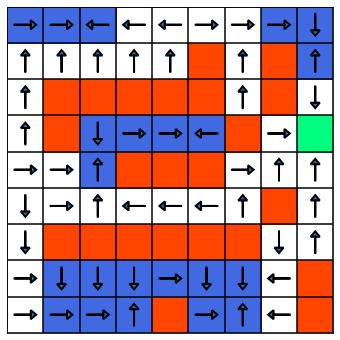

In [ ]:
# only first four actions (Up, Down, Right, Left)
actions = range(4)
V, policy = policyIteration(actions)
print(V,'\n')
plotPolicy(policy)

# Task 3.3

Extend the action set by also allowing diagonal moves, such that the agent can move to its eight neighboring cells.

Use the Value Iteration algorithm to compute the optimal value V\*(s) for each cell.

Indicate the resulting optimal policy π\*(s) with arrows in each cell.

Discuss how value and policy changed, compared to Task 3.2.

[[ 99.99957435  99.99961692  99.99965523  99.9996897   88.99972073  88.99999977  99.99999975  99.9999998   99.99999982]
 [ 99.99965523  99.9996897   99.9996897   99.9996897   88.99972073   0.          99.99999982   0.          99.99999984]
 [ 88.99972073   0.           0.           0.           0.           0.          99.99999952   0.         100.        ]
 [ 88.99999941   0.          99.99999947  99.99999952  99.99999957  99.99999961   0.         100.           0.        ]
 [ 88.99999952  99.99999952  99.99999957   0.           0.           0.          99.99999965 100.         100.        ]
 [ 89.          99.99999961  99.99999961  99.99999961  88.99999965  88.99999969  89.           0.          89.        ]
 [100.           0.           0.           0.           0.           0.           0.         100.          89.        ]
 [100.         100.         100.         100.         100.         100.         100.         100.           0.        ]
 [100.         100.         100.        

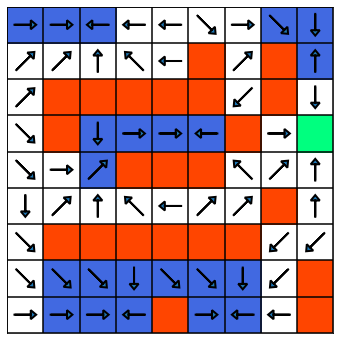

In [ ]:
# all eight actions (diagonal moves allowed as well)
actions = range(8)
V, policy = valueIteration(actions)
print(V,'\n')
plotPolicy(policy)

### Optimal Policy Comparison (Task 3.2 vs 3.3)

1. With the introduction of more moves, it becomes possible to reach G (or higher reward states) more easily (fewer steps) than before from any particular state which leads to higher state value. Therefore, we see in few places, the optimal value has increased as compared to Task 3.2

2. One other way to see it is to see the value of the state around G. It is possible to reach G from 5 states out of which one marked 'x' is not considered. Of the remaining 4 states, it was possible to reach G using non-diagnol move from 3 states and using diagnol move from one state. In Task 3.2, those 3 states have value 100 and the diagnol one - 89 (because can't reach G in one move) whereas for Task 3.3 all 4 states have value 100 because G can be reached in one step for this case.

# Task 3.4

Consider non-deterministic actions, where the agent moves with probability 0.8 into the desired direction, but with probability 0.1 deviates 45° to the left and with probability 0.1 deviates 45° to the right of the desired direction.

Compute again V\*(s) and indicate π\*(s) with arrows.

Discuss how value and policy changed, compared to Task 3.3.

[[77.97918981 76.38986152 74.58877395 72.98560843 67.03602177 77.81690424 87.57442039 89.74419816 88.37785042]
 [80.03823129 80.03823129 78.58877749 75.88561166 67.0360502   0.         87.57449834  0.         90.64680704]
 [71.03440816  0.          0.          0.          0.          0.         88.11416367  0.         98.7653956 ]
 [83.75461674  0.         94.63885605 95.68550278 92.8629175  90.35050665  0.         98.5043956   0.        ]
 [84.63296084 95.23169626 95.26916865  0.          0.          0.         88.11418512 98.5043956  95.6043956 ]
 [84.63298197 94.39233461 92.49233461 92.49233461 79.14152649 77.97685307 84.49292356  0.         87.39295604]
 [98.89999998  0.          0.          0.          0.          0.          0.         96.70329668 88.70329668]
 [99.99999998 99.99999998 99.99999998 99.99999998 99.99999998 99.99999998 99.99999998 99.99999998  0.        ]
 [99.99999998 99.99999999 99.99999999 99.99999999  0.         99.99999999 99.99999999 99.99999999  0.        ]] 

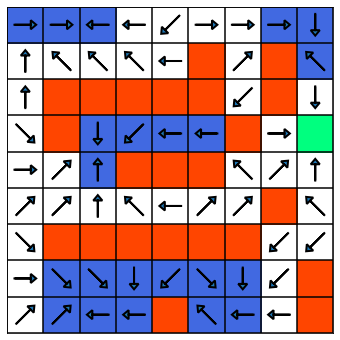

In [ ]:
# all eight actions for non-deterministic
actions = range(8)
V, policy = valueIteration(actions, deterministic=False)
print(V,'\n')
plotPolicy(policy)

### Optimal Policy Comparison (Task 3.3 vs 3.4)

1. At the edges, in Task 3.3 since there was no probability of deviation from action the policy allows movement along the edge if the action value is greater in that direction, though in Task 3.4 it can be since most of those direction point away from the edge - so that even if there is deviation it still doesn't collide with the wall and get a negative reward. Similar is the case for the 'X' where it may also get a negative reward.

2. Interestingly, the action values for both the task is similar despite policy being different as discussed in $1$ : which suggests that for each state there is more than one optimal action(or optimal policy).

### Without Local Rewards
Overall we see places far away from G getting high state value as well - this is because of the presence of local points (+10) and therefore the policy keeps oscillating there. Methods can be further verified by eliminating these local rewards and we should see state values decrease as we move further from 'G'.

[[ 39.2513931   43.612659    48.45851     54.9539      62.171       70.19        72.09        80.1         80.1       ]
 [ 39.2513931   43.612659    48.45851     54.9539      62.171        0.          79.1          0.          89.        ]
 [ 40.1369831    0.           0.           0.           0.           0.          89.           0.         100.        ]
 [ 45.707759     0.          57.6639      64.071       71.19        79.1          0.         100.           0.        ]
 [ 45.707759    51.89751     57.6639       0.           0.           0.          89.         100.         100.        ]
 [ 45.707759    51.89751     54.9539      62.171       70.19        79.1         89.           0.          89.        ]
 [ 45.707759     0.           0.           0.           0.           0.           0.          79.1         79.1       ]
 [ 40.1369831   41.4464931   46.051659    51.16851     56.8539      63.171       70.19        70.19         0.        ]
 [ 37.30184379  41.4464931   46.051659  

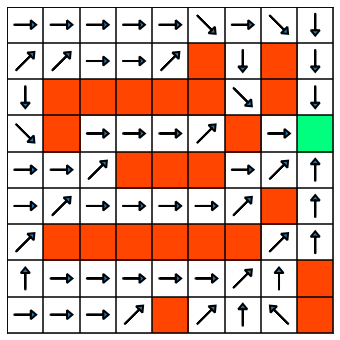

In [ ]:
# removing local rewards
rewards[np.where(rewards==10)] = 0
# all eight actions
actions = range(8)
V, policy = valueIteration(actions)
print(V,'\n')

plt.rc('figure', figsize=(6,6))
ax = plt.gca()
ax.axis([0,gridSize[1],0,gridSize[0]])
ax.grid(True, color='k', linewidth=1.5)
ax.set_aspect(1)
ax.invert_yaxis()
ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none')
for s in np.ndindex(gridSize):
    # if no action possible in state s i.e. obstacle or goal state
    if policy[s].max()==0:
        # if goal state
        if s in goal:
            ax.add_patch(Rectangle((s[1],s[0]),1,1,color='springgreen'))
        # if obstacle
        else:
            ax.add_patch(Rectangle((s[1],s[0]),1,1,color='orangered'))
    else:
        action = np.argmax(policy[s])
        if action==0:
            ax.arrow(s[1]+0.5,s[0]+0.8, 0,-0.6, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif action==1:
            ax.arrow(s[1]+0.5,s[0]+0.2, 0,0.6, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif action==2:
            ax.arrow(s[1]+0.2,s[0]+0.5, 0.6,0, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif action==3:
            ax.arrow(s[1]+0.8,s[0]+0.5, -0.6,0, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif action==4:
            ax.arrow(s[1]+0.25,s[0]+0.75, 0.5,-0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif action==5:
            ax.arrow(s[1]+0.75,s[0]+0.75, -0.5,-0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif action==6:
            ax.arrow(s[1]+0.25,s[0]+0.25, 0.5,0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif action==7:
            ax.arrow(s[1]+0.75,s[0]+0.25, -0.5,0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
plt.show()